# **Motorbike Ambulance Calls**
>Кількість ДТП та відповідних викликів швидкої допомоги значною мірою залежить від природних та сезонних умов, таких як погодні умови, опади, день тижня, сезон, година доби тощо. Дані були зібрані протягом двох років на основі даних про погодинні умови, а потім вилучені та доповнені відповідною погодною та сезонною інформацією.


## **Додаткові завдання**

---


**Регресія**

Прогнозування погодинної кількості викликів швидкої допомоги з урахуванням природних та сезонних умов. Модель прогнозування повинна враховувати монотонність за деякими ознаками, якщо це підтверджується даними.

**Виявлення подій та аномалій**

Визначити моделі викликів швидкої допомоги щодо особливих подій та визначити випадки, які можна вважати ненормальною поведінкою.  

**Результати**

Повнотекстовий звіт, що містить детальний опис процесів аналізу даних, моделювання даних та виявлення закономірностей/аномалій з висновками та їх поясненнями.

Що тут важливо:
* Побачити, як ви мислите - які дії ви виконуєте і чому
* Пропозиції щодо подальшої аналітики/підходів, які можуть бути застосовані

## **Опис даних:**

---



Набір `motorbike_ambulance_calls.csv` містить наступні атрибути:

              - index: record index
              - date : date
              - season : season (1:springer, 2:summer, 3:fall, 4:winter)
              - yr : year (0: 2011, 1:2012)
              - mnth : month ( 1 to 12)
              - hr : hour (0 to 23)
              - holiday : whether day is holiday or not
              - weekday : day of the week
              - workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
              -  weathersit :
                      - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
                      - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
                      - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
                      - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
              - temp : Normalized temperature in Celsius. The values are divided to 41 (max)
              - atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
              - hum: Normalized humidity. The values are divided to 100 (max)
              - windspeed: Normalized wind speed. The values are divided to 67 (max)
              - cnt: count of total ambulance calls (Це наш цільовий атрибут)


##Import libraries & downloading data

In [26]:
import pandas as pd
import numpy as np
import scipy as sc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
#from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import  GridSearchCV
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

NOTES

window -> to categorical (0 or 1)
boosting, random forest, decision tree!

## EDA

In [2]:
df = pd.read_csv('motorbike_ambulance_calls.csv')
df.head()

,index,date,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1/1/11,spring,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2,1/1/11,spring,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,3,1/1/11,spring,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,4,1/1/11,spring,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,5,1/1/11,spring,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [3]:
df.tail()

,index,date,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
17374,17375,12/31/12,spring,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,119
17375,17376,12/31/12,spring,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,89
17376,17377,12/31/12,spring,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,90
17377,17378,12/31/12,spring,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,61
17378,17379,12/31/12,spring,1,12,23,0,1,1,1,0.26,0.2727,0.65,0.1343,49


#### Statistics characteristics

In [4]:
df.describe()

,index,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,189.463088
std,5017.0295,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,181.387599
min,1.0000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,40.000000
50%,8690.0000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,142.000000
75%,13034.5000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,281.000000
max,17379.0000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       17379 non-null  int64  
 1   date        17379 non-null  object 
 2   season      17379 non-null  object 
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  cnt         17379 non-null  int64  
dtypes: float64(4), int64(9), object(2)
memory usage: 2.0+ MB


#### Analysing categorical data

In [6]:
categ_data = df[{'season', 'yr', 'mnth', 'hr', 'holiday', 'workingday', 'weathersit', 'weekday'}]
categ_data.head()

,mnth,weekday,holiday,workingday,weathersit,hr,yr,season
0,1,6,0,0,1,0,0,spring
1,1,6,0,0,1,1,0,spring
2,1,6,0,0,1,2,0,spring
3,1,6,0,0,1,3,0,spring
4,1,6,0,0,1,4,0,spring


#### Tranform seasoon into numbers

In [7]:
categ_data.loc[:, ['season']] = categ_data.season.map({'spring': 1, 'summer': 2, 'autumn': 3, 'winter': 4})
categ_data.season.unique()

array([1, 2, 3, 4])

#### Numerical data

In [8]:
pal = sns.color_palette("Spectral")
sns.set_palette(pal)

In [9]:
num_data = df[{'temp', 'atemp', 'hum', 'windspeed', 'cnt'}]
num_data.head()

,cnt,temp,hum,atemp,windspeed
0,16,0.24,0.81,0.2879,0.0
1,40,0.22,0.80,0.2727,0.0
2,32,0.22,0.80,0.2727,0.0
3,13,0.24,0.75,0.2879,0.0
4,1,0.24,0.75,0.2879,0.0


#### Distribution plots of numerical data

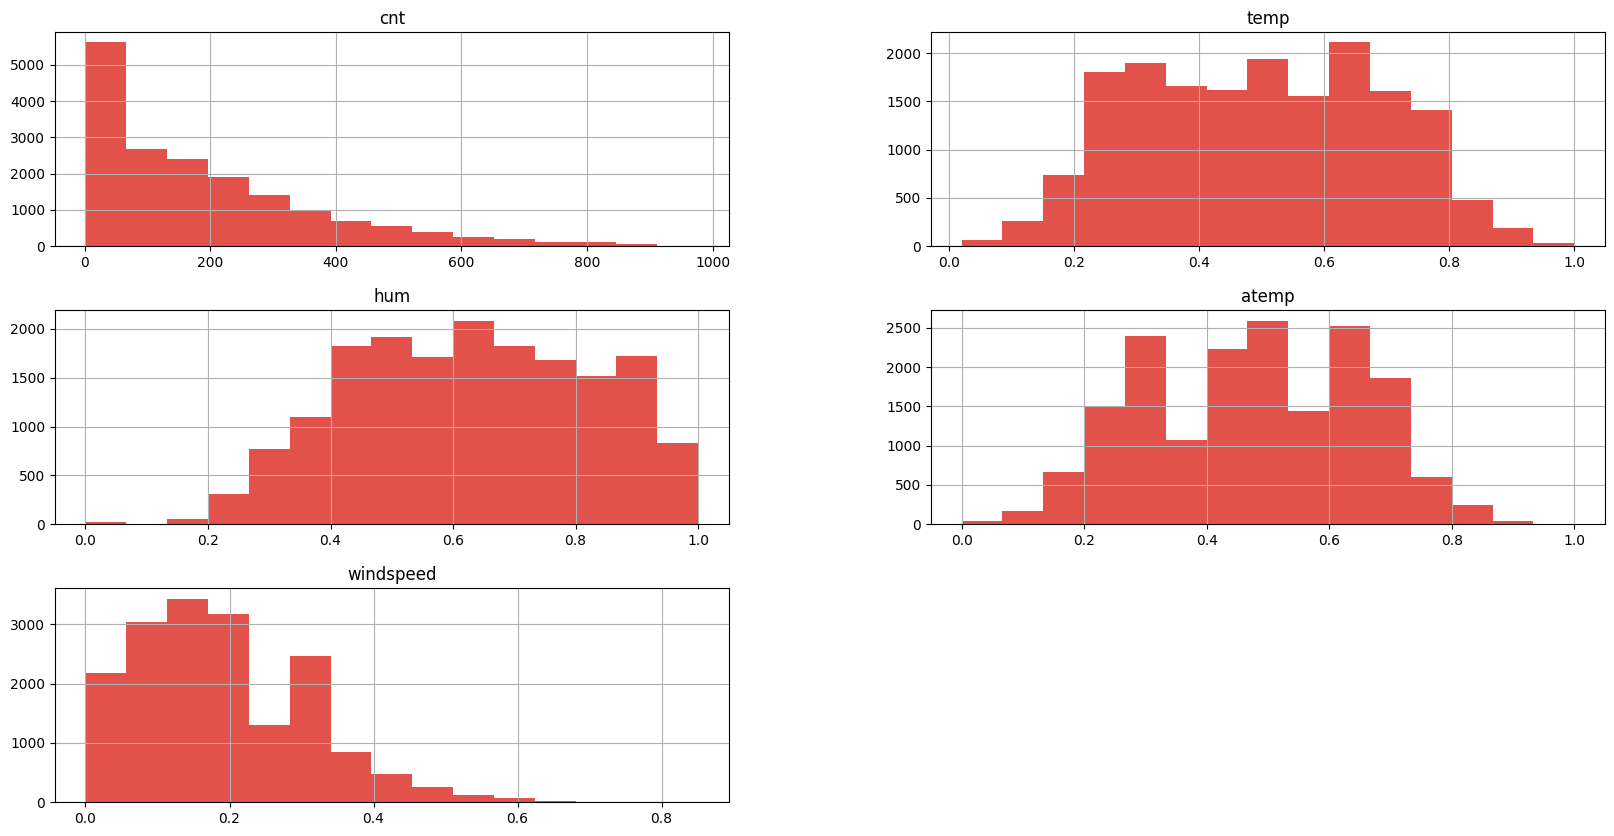

In [10]:
num_data.drop('cnt', axis =1)
num_data.hist(bins=15, figsize=(20, 10), layout=(3, 2))
plt.show()

#### Target

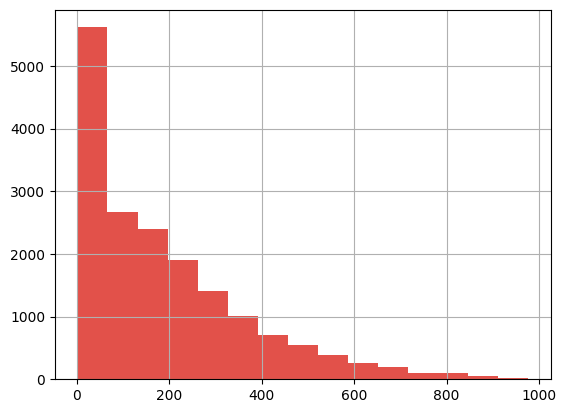

In [11]:
num_data['cnt'].hist(bins=15)
plt.show()

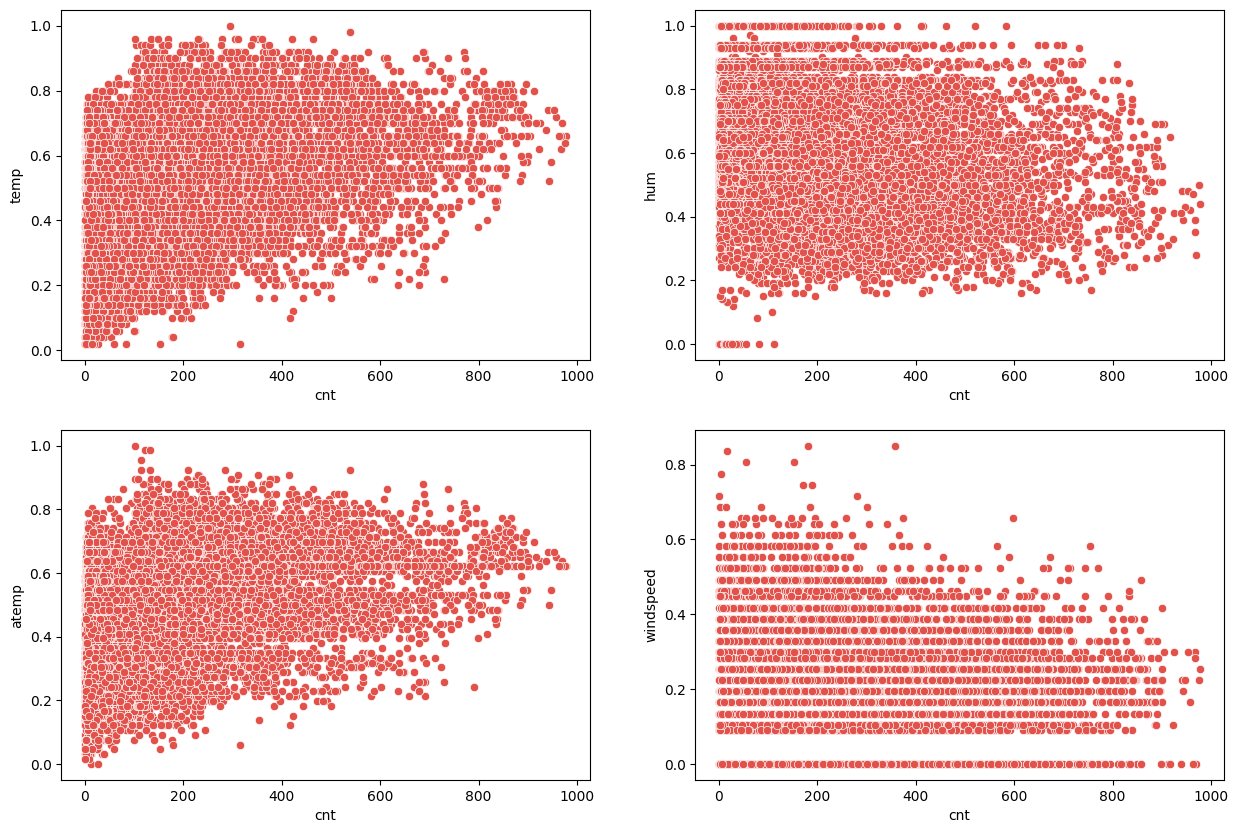

In [12]:
fig, ax = plt.subplots(2,2, figsize = (15,10))
for var, subplot in zip(num_data.drop('cnt', axis =1), ax.flatten()):
    sns.scatterplot(x='cnt', y=var, data=num_data, ax=subplot)

#### Relatationships between categorical and numerical

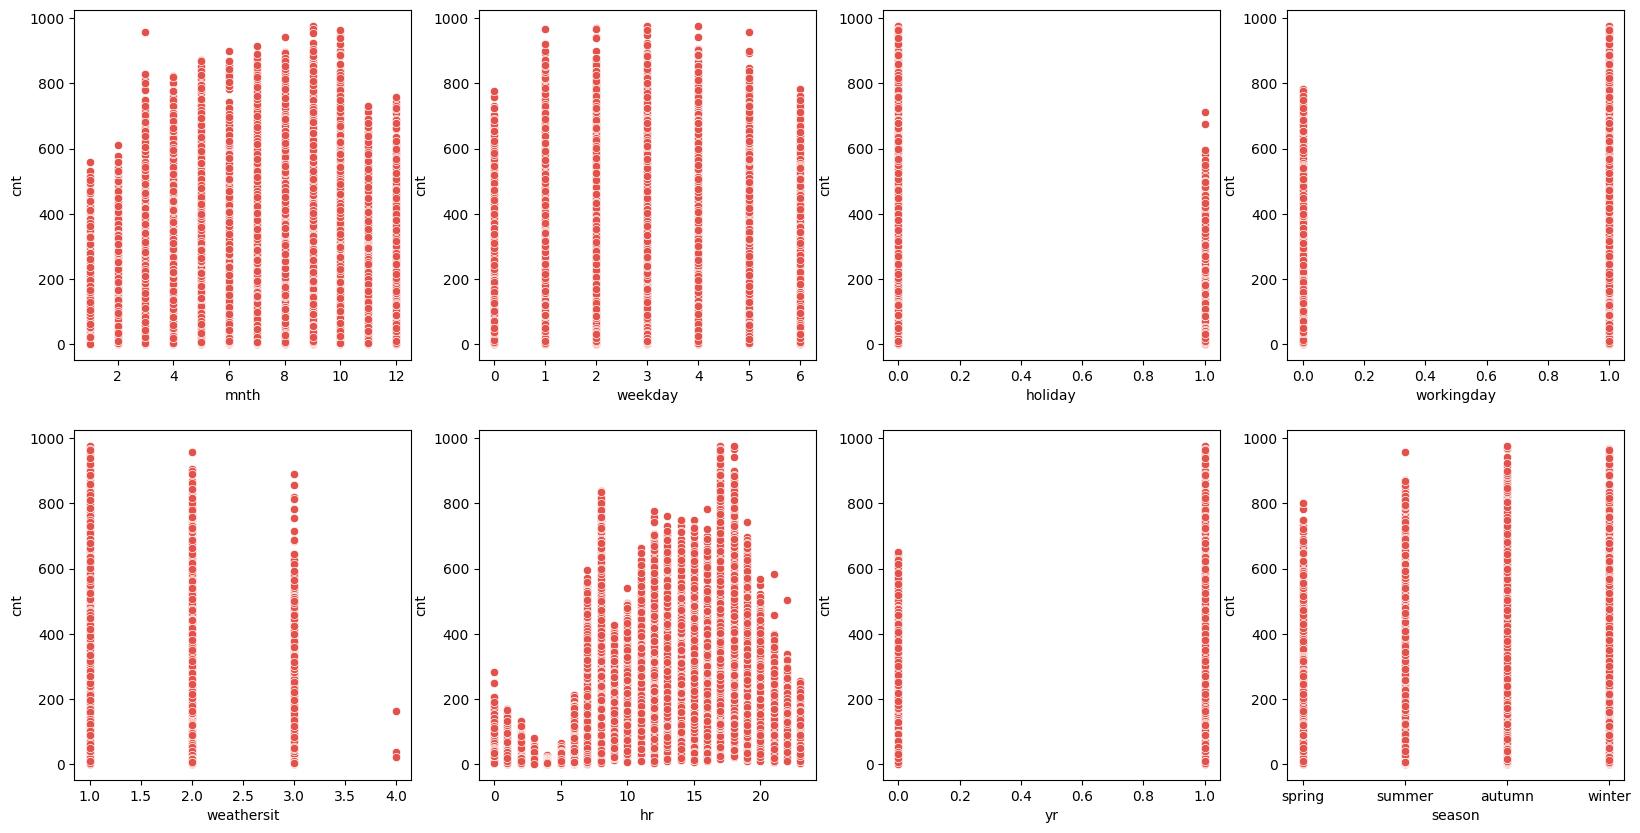

In [13]:
fig, ax = plt.subplots(2,4, figsize = (20,10))
for var, subplot in zip(categ_data, ax.flatten()):
    sns.scatterplot(x=var, y='cnt', data=df, ax=subplot)

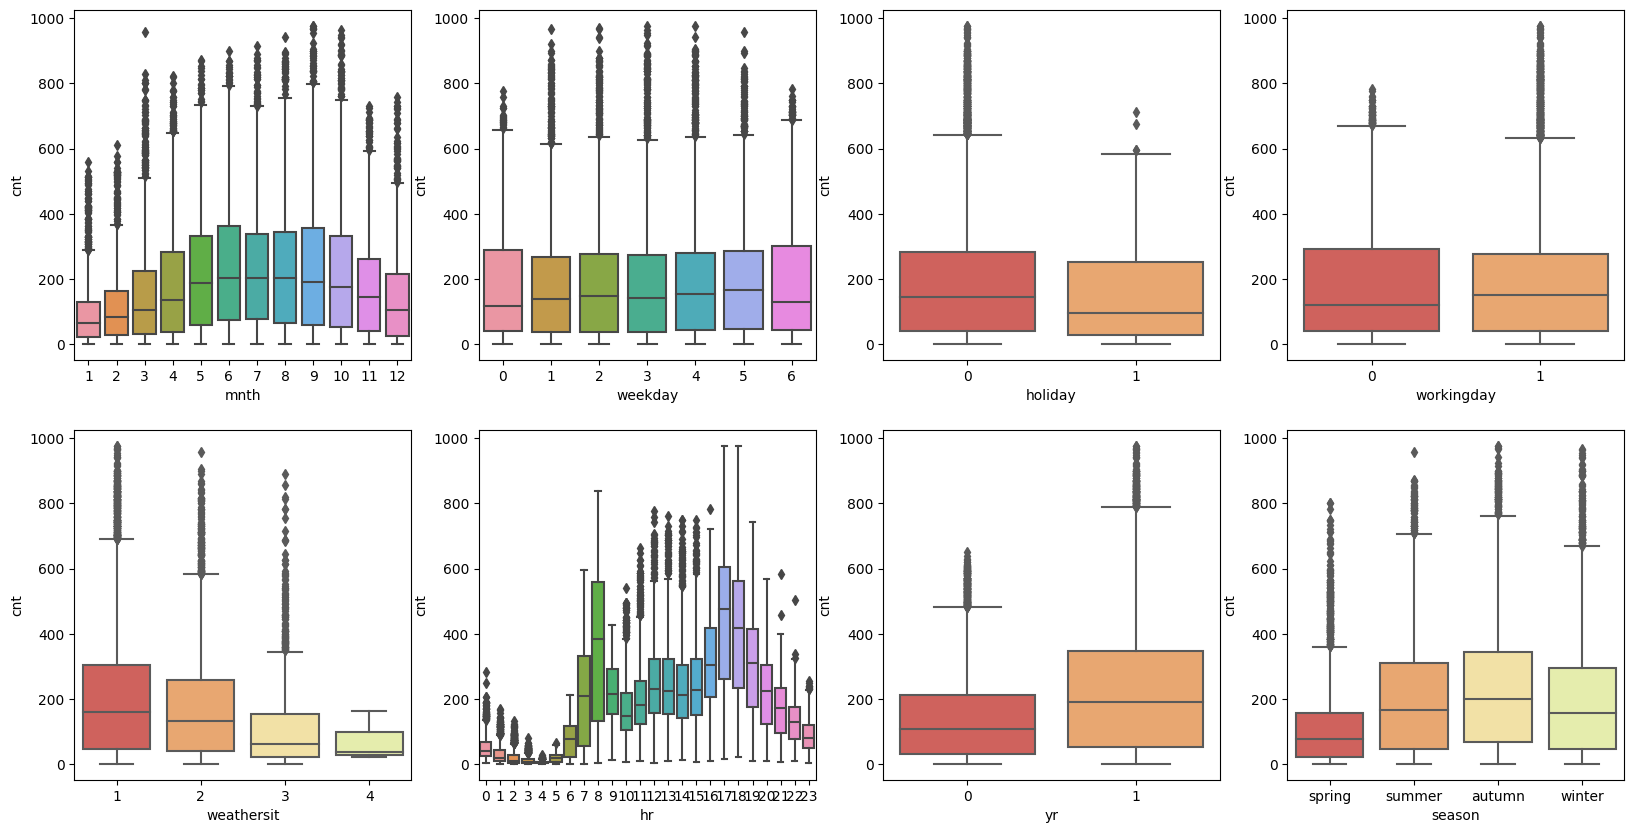

In [14]:
fig, ax = plt.subplots(2,4, figsize = (20,10))
for var, subplot in zip(categ_data, ax.flatten()):
    sns.boxplot(x=var, y='cnt', data=df, ax=subplot)

#### Heatmap

<AxesSubplot: >

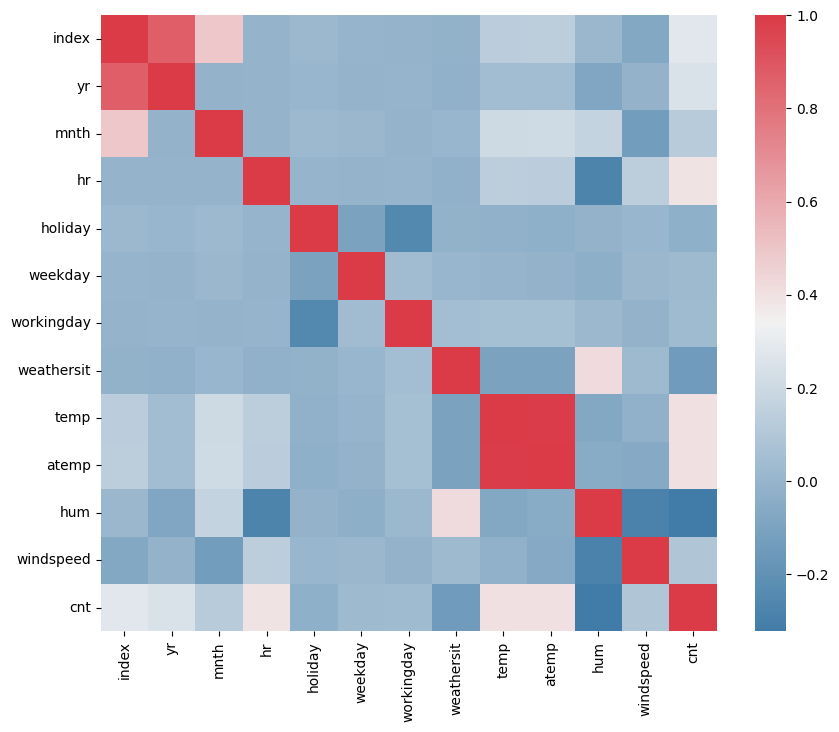

In [15]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(240,10,as_cmap=True),
            square=True, ax=ax)

#### Feature engineering

In [16]:
features = df.drop({'date', 'season', 'mnth', 'weekday', 'weathersit', 'hr', 'index' }, axis =1)

In [17]:
features 

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt
0,0,0,0,0.24,0.2879,0.81,0.0000,16
1,0,0,0,0.22,0.2727,0.80,0.0000,40
2,0,0,0,0.22,0.2727,0.80,0.0000,32
3,0,0,0,0.24,0.2879,0.75,0.0000,13
4,0,0,0,0.24,0.2879,0.75,0.0000,1
...,...,...,...,...,...,...,...,...
17374,1,0,1,0.26,0.2576,0.60,0.1642,119
17375,1,0,1,0.26,0.2576,0.60,0.1642,89
17376,1,0,1,0.26,0.2576,0.60,0.1642,90
17377,1,0,1,0.26,0.2727,0.56,0.1343,61


We can recode windspeed feature to categorical: 0- no wind, 1- windy

In [18]:
features['windspeed'] = np.where((features['windspeed'] == 0), 0, 1)

## Regression

In [19]:
#split data
X = features.drop('cnt', axis=1)
y = features['cnt']

In [20]:
scaler = StandardScaler() #scaler
X = scaler.fit_transform(X) #scaling X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44) #splitting in training and test set

In [21]:
model = LinearRegression()

In [22]:
model.fit(X_train, y_train)

LinearRegression()

In [23]:
model.score(X_train, y_train)

0.30245482712653604

## KNeighborsRegressor

In [27]:
from sklearn.neighbors import KNeighborsRegressor
params = {
    'n_neighbors': [9],  #'n_neighbors': [3,4,5,6,7,8,9,10,11,12], Number of neighbor points to consider for prediction
    'weights': ['distance'],  #'weights': ['uniform', 'distance'], weight function used in prediction
    'p': [1]  #'p': [1,2] # p=1 compute manhattan distance, p=2 compute euclidean distance
    }

knn = KNeighborsRegressor()
rs = GridSearchCV(estimator=knn, param_grid=params, cv=10, n_jobs=-1, scoring='neg_mean_squared_error')
rs.fit(X_train, y_train)
print(rs.best_estimator_)
knn = rs.best_estimator_
knn.fit(X_train, y_train)
pred = knn.predict(X_test)


print('-'*30)
r2 = r2_score(y_test, pred)
print('R2: ', r2)
err = np.sqrt(mean_squared_error(y_test, pred))
print('Root Mean Squared Error: ', err)

knn_reg = ('KNN', r2, err)

KNeighborsRegressor(n_neighbors=9, p=1, weights='distance')
------------------------------
R2:  0.239610502088052
Root Mean Squared Error:  160.19094484961775
